### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'Saccharose hydrolysis'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_pentene.csv',
                                      '../data/PMG_284/preprocessed_triethylsilane.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_hexene.csv',
                                      '../data/PMG_287/preprocessed_triethylsilane.csv',
                                      '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_hydrolysis/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/cut_spectrum_of_mixture/'}

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])


In [6]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    ppm = mixture_time_data.iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [7]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [8]:
mixture_time_data.columns = names

In [9]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [10]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [11]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [12]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [13]:
reagents_spectra

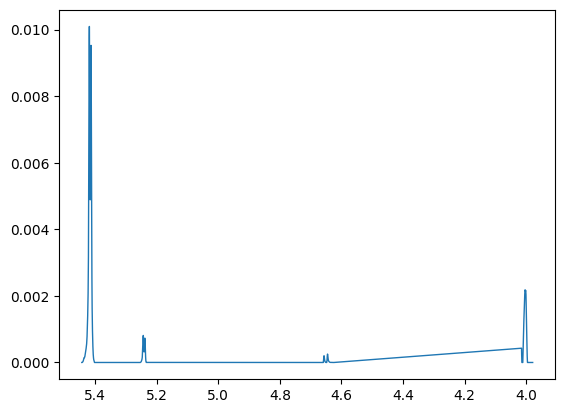

In [14]:
plt.gca().invert_xaxis()
NMRSpectrum.plot(load_spectrum(mixture_time_data, 30), profile=True)
#NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 100)], profile=True)

### Estimation

In [15]:
kappa = 1
kappa_th = 1

In [16]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
#     if i>1:
#         assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-11-13


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.9954424420280005, 0.0021441910810000007, 0.0002213103640000001, 0.002192056527000001]


Proportion_of_noise_in_components:

0.0


This is timepoint 2.

Proportions:

[0.9884352202470005, 0.0051958198700000026, 0.00033852872100000015, 0.006030431162000003]


Proportion_of_noise_in_components:

0.0


This is timepoint 3.

Proportions:

[0.9800719278070009, 0.007894087495000007, 0.0004551042420000004, 0.01157888045600001]


Proportion_of_noise_in_components:

0.0


This is timepoint 4.

Proportions:

[0.9718168485040006, 0.010090944358000007, 0.0006585285810000004, 0.01743367855700001]


Proportion_of_noise_in_components:

0.0


This is timepoint 5.

Proportions:

[0.961906070488, 0.0121506459, 0.000902039944, 0.025041243668]


Proportion_of_noise_in_components:

0.0


This is timepoint 6.

Proportions:

[0.9532890479099996, 0.013720229868999992, 0.0012260874499999993, 0.031764634770999986]


Proportion_of_noise_in_components:

0.0


This is timepoint 7.

Proportions:

[0

Proportions:

[0.5810446734410001, 0.07445367374100001, 0.021607220138000004, 0.32289443268000007]


Proportion_of_noise_in_components:

0.0


This is timepoint 54.

Proportions:

[0.5880502694900002, 0.07460123924700002, 0.022551694038000003, 0.31479679722400006]


Proportion_of_noise_in_components:

0.0


This is timepoint 55.

Proportions:

[0.5321122443440002, 0.07230529082700003, 0.022290481946000012, 0.37329198288200016]


Proportion_of_noise_in_components:

0.0


This is timepoint 56.

Proportions:

[0.5562683959729998, 0.07219878338199998, 0.021169971784999988, 0.35036284885999985]


Proportion_of_noise_in_components:

0.0


This is timepoint 57.

Proportions:

[0.5372411666130001, 0.07704601258600001, 0.023064609093000003, 0.36264821170700007]


Proportion_of_noise_in_components:

0.0


This is timepoint 58.

Proportions:

[0.5309010805639993, 0.07470005631599991, 0.022057196916999974, 0.3723416662029996]


Proportion_of_noise_in_components:

0.0


This is timepoint 59.

Propo

In [17]:
len(proportions_in_times)

103

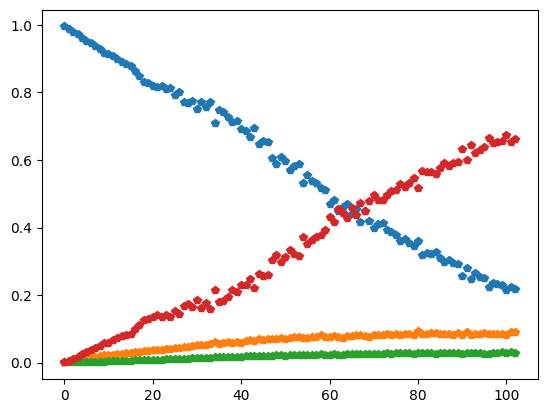

In [18]:
for i in range(len(reagents_spectra)):
    plt.plot(range(len(proportions_in_times)), [prop[i] for prop in proportions_in_times], 'p')

In [19]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [20]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [21]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [22]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [23]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)